In [1]:
%run setup_workspace.ipynb # loads data

In [2]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
from datetime import date
from keras import backend as K 
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
data = daily_energy_consumption
data.ds.min(), data.ds.max()

(datetime.date(2011, 1, 1), datetime.date(2018, 8, 3))

# Creating a Neural Network Model

## 1. Train-test-validation-split

In [4]:
split_date = date(2015,1,1)
split_date2 = date(2015,12,29)
min_date = date(2010,1,1)
max_date = date(2017,1,1)

train = data[data.ds < split_date]
if min_date is not None:
    train = train[train['ds'] > min_date]

valid = data[(data.ds > split_date) & (data.ds < split_date2)]

test = data[data.ds > split_date2]
if max_date is not None:
    test = test[test['ds'] < max_date]

In [5]:
input_len = 14
train_generator = TimeseriesGenerator(train.y.values, train.y.values, length=input_len, batch_size=1)
test_generator = TimeseriesGenerator(test.y.values, test.y.values, length=input_len, batch_size=1)
valid_generator = TimeseriesGenerator(valid.y.values, valid.y.values, length=input_len, batch_size=1)

## Visualization

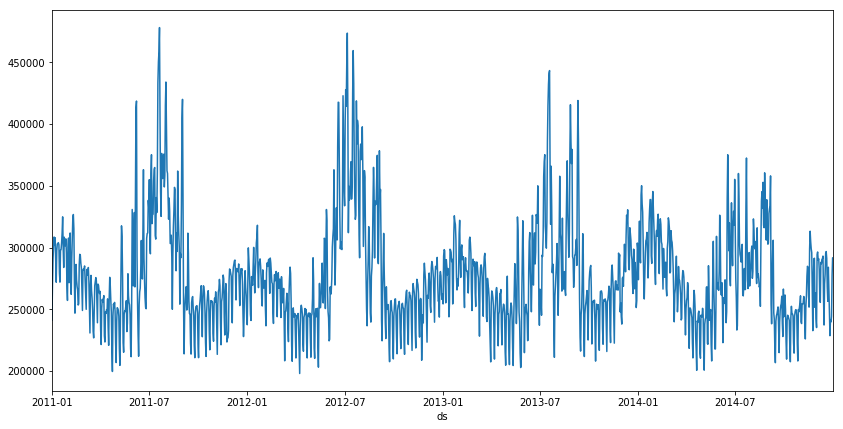

In [6]:
train.set_index('ds').y.plot(figsize=(14,7))

## 2. Model training

In [7]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=input_len))
model.add(Dense(50, activation='relu', input_dim=input_len))
# model.add(Dropout(rate=0.3))
model.add(Dense(1))
model.compile(optimizer='adadelta', loss='mae')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1500      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 6,601
Trainable params: 6,601
Non-trainable params: 0
_________________________________________________________________


In [8]:
%%time
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history =  model.fit_generator(train_generator, steps_per_epoch=5, epochs=150, verbose=0, 
                               callbacks=[earlyStopping], 
                               validation_data=valid_generator)

Instructions for updating:
Use tf.cast instead.
CPU times: user 4.34 s, sys: 784 ms, total: 5.12 s
Wall time: 5.47 s


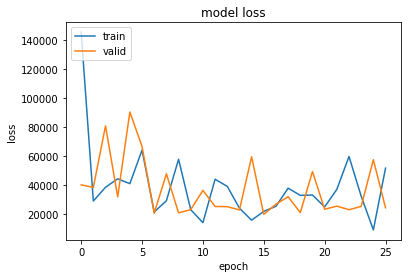

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## 3. Forecast

In [10]:
prediction = model.predict_generator(test_generator)

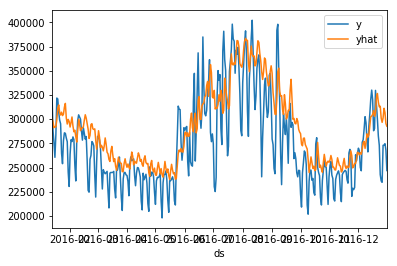

In [11]:
tmp = test.copy().iloc[input_len:,:]
tmp['yhat'] = prediction
tmp.set_index('ds', drop=True).plot()

## 4. Evaluation

In [12]:
error = mean_absolute_percentage_error(test.y[input_len:].values, prediction)
print('MAPE:%0.2f%%'%error)

MAPE:18.13%


In [13]:
# mape_results = []
# for i in range(0,10):
#     model = Sequential()
#     model.add(Dense(50, activation='relu', input_dim=input_len))
#     model.add(Dense(1))
#     model.compile(optimizer='adadelta', loss='mae')
    
#     earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

#     history =  model.fit_generator(train_generator, steps_per_epoch=5, epochs=150, verbose=0, 
#                                callbacks=[earlyStopping], 
#                                validation_data=valid_generator)
    
#     prediction = model.predict_generator(test_generator)
    
#     error = mean_absolute_percentage_error(test.y[input_len:].values, prediction)
#     print('MAPE:%0.2f%%'%error)
#     mape_results.append(error)

# print(np.mean(mape_results))